<a href="https://colab.research.google.com/github/Sri-Chakradhar/Stock_Predictor/blob/main/Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('AAL_data.csv',index_col='Date',parse_dates=True)

In [ ]:
df.head()

,Close
Date,
2013-02-08,14.75
2013-02-11,14.46
2013-02-12,14.27
2013-02-13,14.66
2013-02-14,13.99


<Axes: xlabel='Date'>

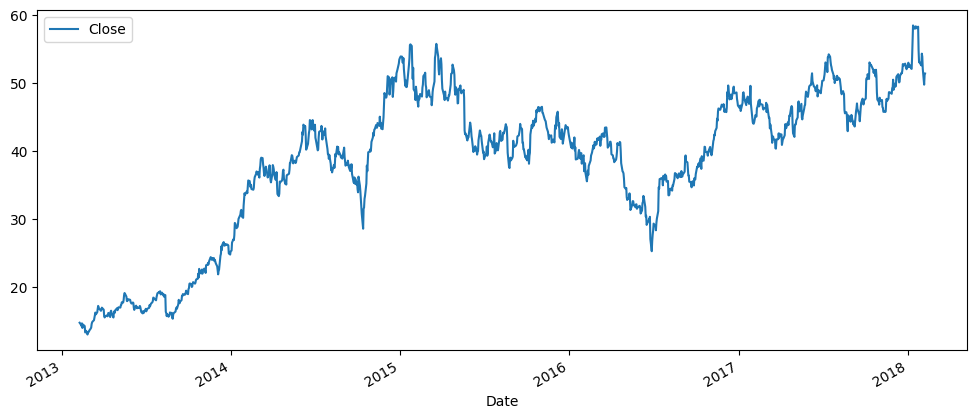

In [ ]:
df.plot(figsize=(12,5))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

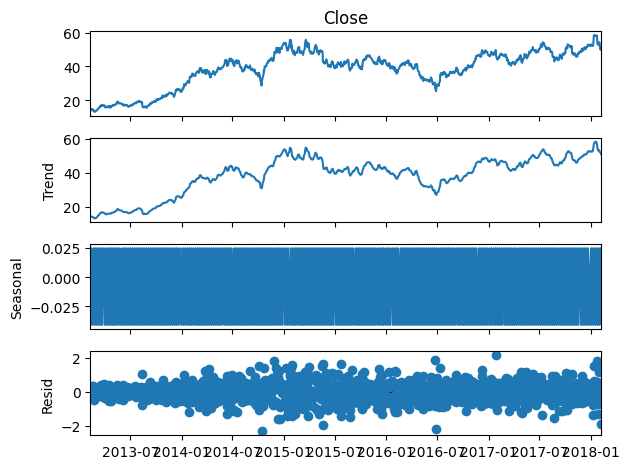

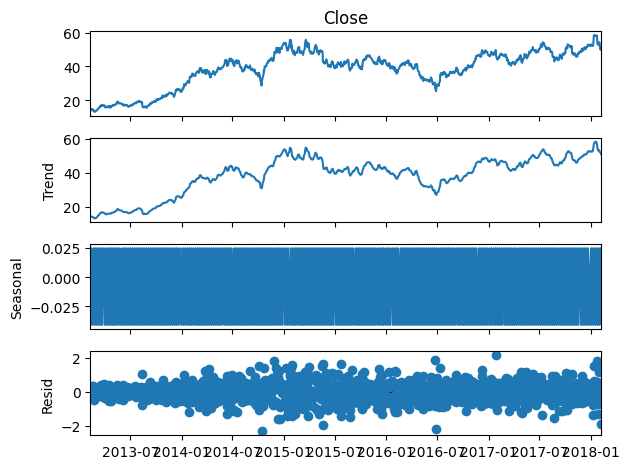

In [ ]:
seasonal = seasonal_decompose(df['Close'],period=5,two_sided=True,extrapolate_trend=2)
seasonal.plot()

In [ ]:
len(df)

1259

In [ ]:
train = df.iloc[:1249]
test = df.iloc[1249:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Close
 Date             
 2013-02-08  14.75
 2013-02-11  14.46
 2013-02-12  14.27
 2013-02-13  14.66
 2013-02-14  13.99,
             Close
 Date             
 2018-02-01  53.88
 2018-02-02  52.10
 2018-02-05  49.76
 2018-02-06  51.18
 2018-02-07  51.40)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.03806381],
       [0.03168317],
       [0.02750275],
       [0.03608361],
       [0.02134213],
       [0.03256326],
       [0.02728273],
       [0.00682068],
       [0.00770077],
       [0.01210121]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_days =50
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_days,batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [ ]:
#define model
model = Sequential()
model.add(LSTM(120,activation='tanh',input_shape=(n_days,scaled_train.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 58681 (229.22 KB)
Trainable params: 58681 (229.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True)

In [ ]:
model.fit_generator(generator,epochs=15,validation_data=generator,callbacks=[early_stop])

Epoch 1/15


<ipython-input-22-e8a13ea74550>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=15,validation_data=generator,callbacks=[early_stop])


1199/1199 [==============================] - 71s 57ms/step - loss: 0.0024 - val_loss: 8.1381e-04
Epoch 2/15
1199/1199 [==============================] - 74s 61ms/step - loss: 0.0010 - val_loss: 6.5990e-04
Epoch 3/15
1199/1199 [==============================] - 65s 54ms/step - loss: 8.0786e-04 - val_loss: 5.2647e-04
Epoch 4/15
1199/1199 [==============================] - 61s 51ms/step - loss: 6.5549e-04 - val_loss: 3.8372e-04
Epoch 5/15
1199/1199 [==============================] - 67s 56ms/step - loss: 6.2294e-04 - val_loss: 8.0988e-04
Epoch 6/15
1199/1199 [==============================] - 62s 52ms/step - loss: 5.9014e-04 - val_loss: 0.0014
Epoch 7/15
1199/1199 [==============================] - 67s 56ms/step - loss: 5.4973e-04 - val_loss: 6.0781e-04
Epoch 8/15
1199/1199 [==============================] - 60s 50ms/step - loss: 5.5819e-04 - val_loss: 3.6968e-04
Epoch 9/15
1199/1199 [==============================] - 63s 52ms/step - loss: 5.4564e-04 - val_loss: 4.4209e-04
Epoch 10/15
119

In [ ]:
last_train_batch = scaled_train[-10:]
n_features = 1
last_train_batch = last_train_batch.reshape((1, n_days, n_features))

ValueError: cannot reshape array of size 10 into shape (1,50,1)

In [ ]:
scaled_test[0]

In [ ]:
model.predict(last_train_batch)

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_days:]
current_batch = first_eval_batch.reshape((1, n_days, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],current_pred.reshape(1,1,1),axis=1) # Reshape current_pred to match dimensions

In [ ]:
test_predictions

In [ ]:
test.head()

In [ ]:
# Convert the list of arrays into a 2D numpy array
test_predictions = np.array(test_predictions).reshape(-1, 1)

# Now you can safely apply the inverse transform
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test.plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Close'],test['Predictions']))
print(rmse)